# Chicago Beach E.coli Prediction in Python

## A data science practice

### Introduction
Chicago has 27 public beaches, along 26 miles of the city's lakefront shoreline, managed by the Chicago Park District.
<br> Here are the beach locations:
![Chicago Beach Locations](https://github.com/agnesbao/chicagobeach/blob/master/Ecoli_test_locations.png?raw=true)

The City of Chicago provides the public with beach water quality data and weather data hour by hour from several sensors during the summer. 
<br>The water quality data is available at https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku. 
<br>The weather data is available at https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75.

Here are the locations of the water and weather sensors:
![](https://github.com/agnesbao/chicagobeach/blob/master/sensor_locations.png?raw=true)

Let's look at the water quality data first using the website's API.

In [1]:
# import packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# fetch data from API
def request_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    return pd.DataFrame(data)

water_url = "https://data.cityofchicago.org/resource/46rk-hgnz.json?$limit=50000"
water_df = request_data(water_url)
water_df = water_df.dropna(subset=['measurement_timestamp'])

The water sensor measures 'turbidity', which is the key measurement of water quality, higher number means the water is more cloudy. In addition, there is 'water_temperature, 'wave_height' and 'wave_period'.
<br> The data starts from May 2014. 
<br> Let's look at which sensors are giving out readings each year.

In [2]:
water_df.index = pd.DatetimeIndex(water_df.measurement_timestamp)
water_df = water_df.sort_index()
for yr in water_df.index.year.unique():
    print(str(yr)+': ')
    print(water_df.beach_name[water_df.index.year==yr].unique())

2013: 
['Montrose Beach' 'Osterman Beach' 'Ohio Street Beach' 'Calumet Beach'
 '63rd Street Beach']
2014: 
['Rainbow Beach' 'Montrose Beach' 'Calumet Beach' 'Ohio Street Beach'
 '63rd Street Beach' 'Osterman Beach']
2015: 
['Rainbow Beach' 'Ohio Street Beach' '63rd Street Beach' 'Calumet Beach'
 'Osterman Beach' 'Montrose Beach']
2016: 
['Ohio Street Beach' 'Montrose Beach' 'Calumet Beach']
2017: 
['Ohio Street Beach']
2018: 
['Calumet Beach']


Oh no, looks like the sensors are dying off. Only the one at Ohio Street Beach is still alive in 2017.

How about the weather data? Are all weather sensors giving readings? Just repeat the same steps as the water data.

In [3]:
weather_url = 'https://data.cityofchicago.org/resource/77jv-5zb8.json?$limit=100000'
weather_df = request_data(weather_url)
weather_df = weather_df.dropna(subset=['measurement_timestamp'])

weather_df.index=pd.DatetimeIndex(weather_df.measurement_timestamp)
weather_df = weather_df.sort_index()
for yr in weather_df.index.year.unique():
    print(str(yr)+': ')
    print(weather_df.station_name[weather_df.index.year==yr].unique())

2015: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']
2016: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']
2017: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']
2018: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']


In order to monitor swimming safety, the city also tests for E.coli level in the water from all 27 beach locations. 
<br>The E.coli lab data is available here: https://data.cityofchicago.org/Parks-Recreation/Beach-Lab-Data/2ivx-z93u
<br>Let's get the lab data.

In [4]:
lab_url = "https://data.cityofchicago.org/resource/awhh-mb2r.json?$limit=50000"
lab_df = request_data(lab_url)
# some dates show the year as 0016, which should be 2016
def fix_date(date_str):
    try:
        return date_str.replace('0016','2016')
    except:
        return None
lab_df.culture_sample_1_timestamp = lab_df.culture_sample_1_timestamp.apply(fix_date)

### Monitor E.coli level: culture testing vs. DNA testing
This dataset contains readings from two E.coli testing techniques. From 2006-2016 the city was using culture-based testing, a slow technique which takes 18-24hrs.  Since 2015 they gradually started DNA testing at several beaches, which only takes a few hours, but is more expensive. All beaches had culture reading untill 2016. In 2017 all tests switched to DNA testing. 
<br> In the data set there are 675 samples that were tested with both techniques. We can use those data to see whether the two techniques are consistent with each other.

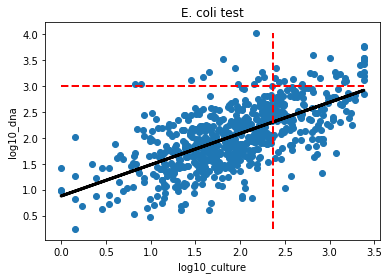

correlation: r=0.6493656610456776; p=4.4164989591122e-82


In [5]:
# dataset with both culture and dna
culture_dna = lab_df.dropna(subset=['dna_reading_mean','culture_reading_mean'])
# log-transform readings, as the distribution is right-skewered
culture_reading = np.log10(culture_dna.culture_reading_mean.astype(float))
dna_reading = np.log10(culture_dna.dna_reading_mean.astype(float))
# threshold for swim advisory 
culture_thresh = np.log10(235)
dna_thresh = np.log10(1000)
# calculate the correlation between culture test and dna test
slope, intercept, r_value, p_value, std_err = linregress(culture_reading, dna_reading)
# plot the relationship between the two testings
plt.scatter(culture_reading,dna_reading)
plt.plot(culture_reading, slope*culture_reading+intercept,'k',linewidth=3)
plt.plot([min(culture_reading),max(culture_reading)],[dna_thresh, dna_thresh],'r--',linewidth=2)
plt.plot([culture_thresh, culture_thresh],[min(dna_reading),max(dna_reading)],'r--',linewidth=2)
plt.xlabel('log10_culture')
plt.ylabel('log10_dna')
plt.title('E. coli test')
plt.show()
print('correlation: r='+str(r_value)+'; p='+str(p_value))

What does this plot tell us?

First, the culture testing and dna testing techniques are positivily correlated with each other, following the fitted black line.

Second, the culture testing gives more alarms than the dna testing: the vertical dashed line is the threshold for culture testing readings: left to the line means the water is safe, right to the line means a swim advisory should be issued. Similarly, the horizontal line is the threshold for dna testing: below the line is safe and above the line is unsafe. Therefore, bottom-left are safe results according to both techniques, upper-right are unsafe results flagged by both, and upper-left are unsafe according to dna but missed by culture testing, and bottom-right are unsafe according to culture but not dna testing.

In summary, using different testing techniques on the same water sample, DNA method gives 6.5% of the samples a red flag, whereas culture method alarms 23.4% of the samples. 

### Predicting swim advisories at Montrose Beach

In the following section, I will use machine learning to predict swim advisories at one beach. The Chi Hack Night has done an awesome project on a similar function last year. Check out: https://chihacknight.org/blog/2017/09/13/clear-water.html

Currently, swim advisories are issued according to the daily lab data. Since dna testing is expensive, it would be economical if we can use wather and weather data to predict swim advisories, and reduce the frequency of lab testing.

For my own practice, I will use water and weather data from 2015 and 2016 to train a classifier model, and test how accurate a swim advisory is issued at Montrose Beach based on the lab data. I will hold out 2017 data as the validation set to test the model performance. 

First, prepare the data set. Basically, I log-transformed any feature that's right-skewed. I summarized hourly water and weather data by calculating the mean and variance of the day. Finally, I included columns that marks the weekday of the date.  

In [6]:
# target data y: Montrose beach, red flag: 1, safe: 0
y = lab_df[(lab_df.beach=='Montrose')]
y = y.dropna(subset=['dna_sample_timestamp'])
y.index = pd.DatetimeIndex(y.dna_sample_timestamp).normalize()
y = y.sort_index()
y = np.log10(y.dna_reading_mean.astype(float))
y = y.drop_duplicates()
y_label = (y>dna_thresh).astype(int)

# features we will use to predict y:
# prepare hourly water data 
water_ft = water_df[['turbidity','water_temperature','wave_height','wave_period']][(water_df.index.year>=2015)&(water_df.beach_name=='Ohio Street Beach')]
water_ft['log_turbidity'] = np.log10(water_ft.turbidity.astype(float)+1)
water_ft.water_temperature = water_ft.water_temperature.astype(float)
water_ft.wave_height = water_ft.wave_height.replace(to_replace='-99999.992', method='pad').astype(float)
water_ft['log_wave_height'] = np.log10(water_ft.wave_height)
water_ft.wave_period = water_ft.wave_period.replace(to_replace='-100000', method='pad').astype(float)
# summarize within date
water_ft = water_ft[['log_turbidity','water_temperature','log_wave_height','wave_period']]
water_ft = water_ft.groupby(water_ft.index.date).mean().join(water_ft.groupby(water_ft.index.date).var(),lsuffix='_mean',rsuffix='_var')

# prepare hourly weather data
weather_ft = weather_df.drop(['battery_life','measurement_id','measurement_timestamp','measurement_timestamp_label','station_name','precipitation_type','heading'],axis=1).astype(float)
weather_ft[['station_name']] = weather_df[['station_name']]
weather_ft['log_interval_rain'] = np.log10(weather_ft.interval_rain+1)
weather_ft['log_maximum_wind_speed'] = np.log10(weather_ft.maximum_wind_speed+1)
weather_ft['log_rain_intensity'] = np.log10(weather_ft.rain_intensity+1)
weather_ft['log_total_rain'] = np.log10(weather_ft.total_rain+1)
weather_ft.wind_speed = weather_ft.wind_speed.replace(to_replace=999.9, method='pad')
weather_ft['log_wind_speed'] = np.log10(weather_ft.wind_speed+1)
weather_ft = weather_ft.drop(['interval_rain','maximum_wind_speed','rain_intensity','total_rain','wind_speed'],axis=1)
# summarize within date
temp_df = pd.DataFrame()
for i in weather_ft.station_name.unique():
    df = weather_ft[weather_ft.station_name==i]
    temp_df = temp_df.join(df.resample('D').mean(),how='outer',rsuffix='_mean_'+i)
    temp_df = temp_df.join(df.resample('D').var(),how='outer',rsuffix='_var_'+i)
weather_ft = temp_df

# preparing predictor X
df = weather_ft
df = df.join(y,how='right')
df = df.join(water_ft,how='left')
df = df.drop(['dna_reading_mean'],axis=1)
X = df

# add weekday variable 
X['weekday']=X.index.weekday_name
X = pd.get_dummies(X)

First of all, which machine learning model to use?

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

test_year = 2017
X_train = X[X.index.year<test_year]
y_train = y_label[y_label.index.year<test_year]
X_test = X[X.index.year==test_year]
y_test = y_label[y_label.index.year==test_year]

In [8]:
# model selection
modelnamelist = ['Neural Net','Nearest Neighbors','SVM','Random Forest','Naive Bayes','Logistic Regression']
modellist = [MLPClassifier(solver='lbfgs'),KNeighborsClassifier(),SVC(),RandomForestClassifier(),GaussianNB(),LogisticRegression()]
for name, model in zip(modelnamelist,modellist):
    imp = Imputer(missing_values='NaN', strategy='median')
    steps = [('imputation', imp),
             ('scaler',StandardScaler()),
             ('model',model)]
    pipeline = Pipeline(steps)
    accuracy = cross_val_score(pipeline, X_train, y_train)
    recall = cross_val_score(pipeline, X_train, y_train, scoring='recall')
    print(name, ' accuracy:', accuracy.mean(), ' recall:', recall.mean())

Neural Net  accuracy: 0.8324561403508771  recall: 0.38888888888888884
Nearest Neighbors  accuracy: 0.9070175438596492  recall: 0.0
SVM  accuracy: 0.9070175438596492  recall: 0.0
Random Forest  accuracy: 0.8986842105263158  recall: 0.0
Naive Bayes  accuracy: 0.6346491228070176  recall: 0.3333333333333333
Logistic Regression  accuracy: 0.7736842105263158  recall: 0.47222222222222215


Seems logistic regression has the best performance on recall. 
Step 2, we can tune the hyper-parameters using grid search:

In [9]:
# Hyperparameter tuning 
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('model',LogisticRegression())]
pipeline = Pipeline(steps)
parameters = {'model__C': np.logspace(-10,10,11)}
cv = GridSearchCV(pipeline, param_grid=parameters, scoring='recall')
cv.fit(X_train, y_train)
print('Best hyper-parameter')
print(cv.best_params_)
print('Classficiation report on test data from 2017:')
y_pred = cv.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:'+str(np.mean(y_test==y_pred)))

Best hyper-parameter
{'model__C': 1e-10}
Classficiation report on test data from 2017:
             precision    recall  f1-score   support

          0       0.86      0.94      0.90        79
          1       0.67      0.45      0.54        22

avg / total       0.82      0.83      0.82       101

Accuracy:0.8316831683168316


In [10]:
y_trace = y[y.index.year==test_year]
plt.plot(y_trace)
plt.plot(y_trace[np.equal(y_pred,1)&(y_test.values==1)],'go')
plt.plot(y_trace[np.equal(y_pred,0)&(y_test.values==1)],'ro')
plt.plot(y_trace[np.equal(y_pred,1)&(y_test.values==0)],'rx')
plt.xticks(rotation=45)
plt.ylabel('log10_dna_reading')
plt.legend(['dna_reading','hit','miss','false alarm'],loc='center left', bbox_to_anchor=(1, 0.5))

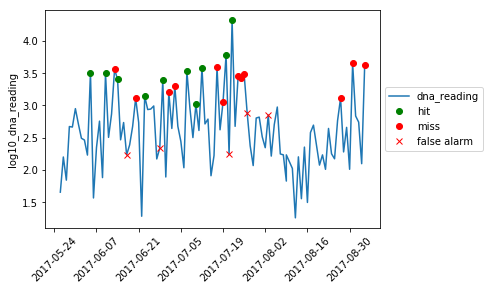

In [11]:
plt.show()

To summarize: in the 2017 season, there are 22 days when the Montrose beach was tested as unsafe. My logistic regression classifier identified 10 of them (45%, green dots) correctly, based only on water and weather sensor data. There are 5 days when the classifer issued a false alarm (red cross). The total accuracy is 83%.

In [12]:
coef = cv.best_estimator_.steps[2][1].coef_.squeeze()
coef_rank = np.argsort(abs(coef))
print('Top 10 important features:')
print(pd.Series(coef[coef_rank[-10:]], index=X.columns[coef_rank[-10:]]).sort_values(ascending=False))

Top 10 important features:
air_temperature_var_63rd Street Weather Station           8.619793e-10
air_temperature_var_Oak Street Weather Station            8.589872e-10
log_maximum_wind_speed_var_63rd Street Weather Station    8.029878e-10
log_rain_intensity_mean_Foster Weather Station            7.888092e-10
wind_direction_mean_Foster Weather Station                7.563153e-10
log_rain_intensity_var_63rd Street Weather Station        6.792798e-10
humidity_var_Foster Weather Station                       6.742172e-10
log_rain_intensity_mean_Oak Street Weather Station        6.732144e-10
log_interval_rain_var_Oak Street Weather Station          6.626513e-10
log_interval_rain_mean_Oak Street Weather Station         6.606774e-10
dtype: float64
